<a href="https://colab.research.google.com/github/annnyway/QA-for-Russian/blob/master/Dataset_subset_for_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip3 install razdel pytorch_pretrained_bert regex
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from razdel import tokenize
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertForMaskedLM, BertConfig
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def tokenize_text(text):
    """Токенизация"""
    words = [_.text for _ in list(tokenize(text))]
    return words


class QADataset(Dataset):

    def __init__(self, tokenizer: BertTokenizer,
                 paragraph_tokens: list,
                 question_tokens: list,
                 answer_spans: list,
                 word2index: dict,
                 verbose=True,
                 max_seq_len=512,
                pad_token="[PAD]"):

        super().__init__()
        self.tokenizer = tokenizer
        self.word2index = word2index
        self.word2bert_tokens = {word: self.tokenizer.tokenize(word) for word
                                 in tqdm(list(self.word2index.keys())[1:])}
        self.word2bert_indices = {
            word: [self.tokenizer.vocab[bert_token] for bert_token in
                   self.word2bert_tokens[word]] for word in
            self.word2bert_tokens.keys()}

        self.sequence_length = max_seq_len
        self.pad_index = self.word2index[pad_token]

        self.x_data = []
        # self.load_x(paragraph_tokens, question_tokens, verbose=verbose)
        self.y_data = []
        # self.load_y(answer_spans)
        self.load_x_y(paragraph_tokens, question_tokens, answer_spans)

    def load_x_y(self, paragraphs, questions, spans, verbose=True):
        for par, quest, span in tqdm(zip(paragraphs, questions, spans),
                                     desc="Loading data", disable=not verbose):
            tokens = ["[CLS]"] + par + ["[SEP]"] + quest + ["[SEP]"]
            start, end = span.split(",")
            start, end = int(start), int(end)
            bert_tokens = [self.word2bert_indices[word] for word in tokens]
            bert_span_start = sum(len(x) for x in bert_tokens[:start + 1])
            bert_span_end = sum(len(x) for x in bert_tokens[:end + 1]) # прибавляем 1, т.к. у нас в начале есть еще токен CLS
            span = (bert_span_start, bert_span_end) 
            
            bert_tokens = sum(bert_tokens, [])
            if len(bert_tokens) > 512:
                par_tokens = [self.word2bert_indices[word] for word in ["[CLS]"] + par]
                quest_tokens = [self.word2bert_indices[word] for word in ["[SEP]"] + quest + ["[SEP]"]]
                if bert_span_start <= len(par_tokens)/2: # если спан в первой половине параграфа
                    slice_ = len(bert_tokens) - 512
                    bert_tokens = sum(par_tokens[:-slice_] + quest_tokens, [])
                elif bert_span_start > len(par_tokens)/2:
                    slice_ = len(bert_tokens) - 512
                    bert_tokens = sum(par_tokens[slice_:] + quest_tokens, [])
                    bert_span_start = bert_span_start - slice_
                    bert_span_end = bert_span_end - slice_
                    span = (bert_span_start, bert_span_end)
                elif bert_span_start > 1024:
                    factor = floor(len(bert_tokens)/512)
                    slice_ = len(bert_tokens) - 512*factor
                    bert_tokens = sum(par_tokens[slice_:] + quest_tokens, [])
                    bert_span_start = bert_span_start - slice_
                    bert_span_end = bert_span_end - slice_
                    span = (bert_span_start, bert_span_end)

                    
            self.x_data.append(bert_tokens)
            self.y_data.append(span)

    def padding(self, sequence):
        if len(sequence) > self.sequence_length:
            sequence = sequence[: self.sequence_length]
        elif len(sequence) < self.sequence_length:
            sequence += [self.pad_index for i in
                         range(self.sequence_length - len(sequence))]
        return sequence

    def create_y_matrix(self, span):
        startspan = span[0]
        endspan = span[1]
        ansten = torch.zeros(512).long()
        for i in range(startspan, endspan):
            if i <= 512:
                ansten[i] = 1
            else:
                continue
        return ansten  


    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):

        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        y = self.y_data[idx]
        y = self.create_y_matrix(y)
        return x, y

In [0]:
data = pd.read_csv("/content/drive/My Drive/COLABDRIVE/sdsj2017_sberquad_with_spans(minus_30_examples).csv")

In [0]:
## Можно просто скопировать эту часть в вашу тетрадь 
data['span_len'] = data.apply(lambda row: int(row.word_answer_span.split(",")[1]) - int(row.word_answer_span.split(",")[0]), axis = 1) 
data['span_avg'] = data.apply(lambda row: (int(row.word_answer_span.split(",")[1])+int(row.word_answer_span.split(",")[0]))/2, axis = 1)
data_select = data[(data.span_len <= 10) & (data.span_avg <= 150)]
data_select.sample(frac=0.11) 

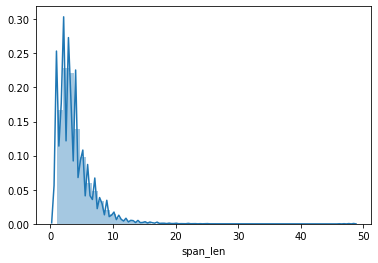

In [74]:
sns.distplot(data.span_len) 

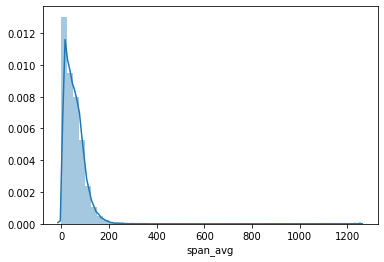

In [75]:
sns.distplot(data.span_avg)

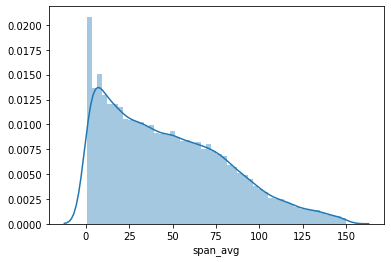

In [84]:
sns.distplot(data_select.span_avg)